In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import tensorflow as tf
print('TF Version: ' + str(tf.__version__))
physical_devices = tf.config.list_physical_devices('GPU')
print('GPUs: ' + str(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

TF Version: 2.8.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.model import BIC
from src.parsing import load_dataset
from src.parsing import preprocess
from src.parsing import instantiate_radial_vectors
from src.learning import loss_func

### Parameters
Here especially the `translation` is of interest.

In [23]:
dataset_name = 'coil100' # 'coil100' 'lfw', 'fashion_mnist', 'cifar10', 'cifar100', 'imagenet', 'celeba', 'widerface'
target_size = 128 // 2
model_path = './model/coil100.h5py'
margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))
translation = -4
batch_size = 128
n_beams = 16
continuous = False
n_pixels = 64
n_channels = 3

### BIC Model Building

In [15]:
# input tensor (batch x (zero, theta) x beams x (2epsilon + 1) x D x C)
in_beams = tf.keras.layers.Input([2, n_beams, 3, n_pixels, n_channels])

bic = BIC(hidden=128, activation=tf.nn.leaky_relu, context=True,
          l2_regularization=0.0, edge_factor=0.5, gcn_layers=3, dropout=0.0,
          size_vector_field=n_beams, pixel_count_per_vector=n_pixels)

# multiple output for introspection; for training and inference: prior and unit_vec are essential
prior, unit_vec, beamencoding, ctx, similarity, \
beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding = bic(inputs=in_beams)

model = tf.keras.models.Model(inputs=in_beams, name='bic',
                              outputs=(prior, unit_vec, beamencoding, ctx, similarity, \
                                       beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding))

model = tf.keras.models.load_model(model_path)

model.summary()

Model: "bic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 beams (InputLayer)          [(None, 2, 16, 3, 64, 3)  0         
                             ]                                   
                                                                 
 bic (BIC)                   ((None, 16),              560226    
                              (None, 2),                         
                              (None, 2, 16, 128),                
                              (None, 2, 128),                    
                              (None, 16, 16),                    
                              (None, 16, 128),                   
                              (None, 16, 128),                   
                              (None, 16, 16),                    
                              (None, 128))                       
                                                               

### Load Dataset
Due to the additional translation, we load and pre-process the dataset from skretch.

In [16]:
dataset = load_dataset(dataset_name, partial=None)

margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))

n_train = int(0.8 * float(dataset.cardinality()))
n_val = int(0.1 * float(dataset.cardinality()))
n_test = int(0.1 * float(dataset.cardinality()))

### Test BIC on a range of translation pertubations
Due to the symmetric and centered beam field, the direction of the translation does not matter.
Here we translate the image to one corner.

In [25]:
translation_lower_bound = -5 
translation_upper_bound = 6

performance = []
for translation in tqdm(np.arange(translation_lower_bound, translation_upper_bound)):
    train_dataset = dataset.take(n_train)
    val_dataset = dataset.skip(n_train).take(n_val)
    test_dataset = dataset.skip(n_train).skip(n_val).take(n_train)
    
    img_size = int(train_dataset.element_spec['image'].shape[0])
    lines, angles = instantiate_radial_vectors(img_size + margin_padding, img_size + margin_padding,
                                               beam_set_size=n_beams,
                                               max_len=target_size)
    
    test_dataset = preprocess(test_dataset, lines, angles, target_size=img_size + margin_padding,
                              batch_size=batch_size, path='./test_dataset', continuous=continuous,
                              horizontal_translation=translation,
                              vertical_translation=translation)

    _, n_vec, _, n_pixels, n_channels = test_dataset.element_spec['vec'].shape

    angles = tf.cast(angles, tf.float32)

    losses = []
    for sample in test_dataset:
        x = tf.concat([sample['vec'][:, None], sample['vec_rot'][:, None]], axis=1)
        pred_facts, pred_angle, conv_latents, gnn_latents, distance_matrix, \
        x1_emb, x2_emb, angle_energy, rnn_encoding = model(x)

        unit_circle_loss, toeplitz_loss = loss_func(pred_angle, pred_facts, angles,
                                                    sample['angle'], continuous=continuous)
        losses.append(unit_circle_loss)
    performance.append(losses)

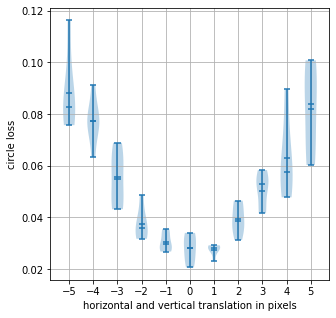

In [26]:
plt.figure(figsize=(5, 5))
plt.violinplot(performance, np.arange(-5, 6), points=20, widths=0.5,
               showmeans=True, showextrema=True, showmedians=True)
plt.xticks(np.arange(-5, 6))
plt.ylabel('circle loss')
plt.xlabel('horizontal and vertical translation in pixels')
plt.grid(True)
plt.show()